In [1]:
import os
import random
import gc
import argparse
import numpy as np
import h5py as h5
import torch
import torch.nn.functional as F
import wandb

from models.vae import VAE 
from losses.cyl_ptpz_mae import CylPtPzMAE

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#setting a seed like in vae_legacy
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
#calculated disco loss based on paper
def disco_loss(z1, z2):
    #center around 0
    x = z1 - z1.mean(0)
    y = z2 - z2.mean(0)
    #build euclidean distance matrices
    a = torch.cdist(x, x)
    b = torch.cdist(y, y)
    #doublce center distance matrices
    A = a - a.mean(0) - a.mean(1, keepdim=True) + a.mean()
    B = b - b.mean(0) - b.mean(1, keepdim=True) + b.mean()
    #find covariance
    dcov = (A * B).mean()
    #find variance and take square root (in paper it is not squared)
    dvar_x = (A * A).mean().sqrt()
    dvar_y = (B * B).mean().sqrt()
    #return paper formula for disco
    return dcov / (dvar_x * dvar_y + 1e-10)

In [4]:
#calculates anomaly score like in vae legacy
def distance_pt(model_vae, data_np, device):
    x = torch.tensor(data_np, dtype=torch.float32, device=device)
    z_mean, z_logvar, _ = model_vae.encoder(x)
    score = torch.sum(z_mean**2, dim=1)
    return score.detach().cpu().numpy()

In [5]:
def run(config):
    #set seed
    seed = 123
    set_seed(seed)

    #move to gpu if avail
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")

    #login to wandb
    print("Logging in to wandb...")
    wandb.login(key="24d1d60ce26563c74d290d7b487cb104fc251271")
    wandb.init(project="Double Disco Axo Training",
               settings=wandb.Settings(_disable_stats=True),
               config=config)
    run_name = wandb.run.name
    print(f"Run name: {run_name}")

    #scaling
    beta = float(config['beta'])
    alpha = float(config['alpha'])
    vae_lr = float(config['vae_lr'])

    #load data
    print("Loading dataset...")
    fpath = '/axovol/training/v5/conditionsupdate_apr25.h5'
    with h5.File(fpath, 'r') as f:
        root = f['data'] if 'data' in f else f
    
        x_train = root['Background_data']['Train']['DATA'][:]
        x_test = root['Background_data']['Test']['DATA'][:]
        print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
    
        #flatten per event
        x_train_bkg = x_train.reshape(x_train.shape[0], -1)
        x_test_bkg  = x_test.reshape(x_test.shape[0], -1)
    
        scale = root['Normalisation']['norm_scale'][:]
        bias = root['Normalisation']['norm_bias'][:]
    
        l1_bits_bkg_test = root['Background_data']['Test']['L1bits'][:]
    
        #load signal data
        SIGNAL_NAMES = list(root['Signal_data'].keys())
        signal_data_dict = {}
        signal_l1_dict = {}
        for sname in SIGNAL_NAMES:
            x_sig = root['Signal_data'][sname]['DATA'][:]
            x_sig = x_sig.reshape(x_sig.shape[0], -1)
            l1_bits = root['Signal_data'][sname]['L1bits'][:]
            signal_data_dict[sname] = x_sig
            signal_l1_dict[sname] = l1_bits

    print("Data finished loading.")
    
    dataset = x_train_bkg
    dataset_test = x_test_bkg

    #should be 57
    features = dataset.shape[1]


    print("Building mask...")
    # same mask from vae legacy
    mask_dict = {
        "MET":[True],
        "EGAMMA":[True,True,True,True,False,False,False,False,False,False,False,False],
        "MUON":[True,True,True,True,False,False,False,False],
        "JET":[True,True,True,True,True,True,True,True,True,True,False,False]
    }
    
    #build cyl_ptpz_mae mask (input scales and biases)
    reco_loss_fn = CylPtPzMAE(scale, bias).to(device)
    print("Mask is ready.")


    #vae config
    latent_dim = int(config['vae_latent'])
    enc_nodes = list(config['vae_nodes'])
    dec_nodes = [24, 32, 64, 128, features] 

    vae_cfg = {
        "features": features,
        "latent_dim": latent_dim,
        "encoder_config": {"nodes": enc_nodes},
        "decoder_config": {"nodes": dec_nodes},
        "alpha": alpha,
        "beta":  beta,
    }

    #put vae on device/init
    vae_1 = VAE(vae_cfg).to(device)
    vae_2 = VAE(vae_cfg).to(device)
    print("VAEs are ready.")

    #optimizer (adam)
    optimizer = torch.optim.Adam(list(vae_1.parameters()) + list(vae_2.parameters()), lr=vae_lr)

    #cosine restarts
    warmup_epochs = 10
    cos = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=32, T_mult=2, eta_min=0.0)

    #sets learning rate
    def set_lr(lr):
        for g in optimizer.param_groups:
            g['lr'] = lr

    #hyperparameters
    Epochs_VAE = 50
    Batch_size = 16384

    #get disco param from config, else set to 1
    lambda_disco = float(config.get("lambda_disco", 1))

    print("Moving data to device...")
    X = torch.tensor(dataset, dtype=torch.float32, device=device)
    print("Data on device.")

    #training loop
    print("Starting the training loop!")
    N = X.size(0)
    for epoch in range(Epochs_VAE):
        #cosine warmup step (sets the learning rate based on cosine schedule)
        if epoch < warmup_epochs:
            lr = vae_lr * (epoch + 1) / warmup_epochs
            set_lr(lr)
        else:
            cos.step(epoch - warmup_epochs)

        #shuffles data incides for each epoch
        perm = torch.randperm(N, device=device)

        #init losses
        total_loss = total_reco1 = total_reco2 = total_kl1 = total_kl2 = total_disco = 0.0

        #loops over dataset in steps of batch sizze
        for i in range(0, N, Batch_size):
            #picks indices for current batch
            idx = perm[i:i+Batch_size]

            #selects batch of samples from data set X
            xb  = X[idx]

            #vae 1
            recon1, mu1, logvar1, z1 = vae_1(xb)
            
            #vae 2
            recon2, mu2, logvar2, z2 = vae_2(xb)

            #get reco loss from custom func
            reco1_per = reco_loss_fn(recon1, xb)
            reco2_per = reco_loss_fn(recon2, xb)

            #get kl div per sample
            kl1_per = VAE.kl_divergence(mu1, logvar1)
            kl2_per = VAE.kl_divergence(mu2, logvar2)

            #same scaling from vae legacy
            reco1 = vae_1.reco_scale*reco1_per.mean()
            reco2 = vae_2.reco_scale*reco2_per.mean()
            kl1 = vae_1.kl_scale*kl1_per.mean()
            kl2 = vae_2.kl_scale*kl2_per.mean()

            #disco loss (ask Melissa about since using mu instead of z)
            disco = disco_loss(mu1, mu2)

            #calc total loss
            loss = (reco1 + kl1) + (reco2 + kl2) + lambda_disco * disco

            #zero grads
            optimizer.zero_grad(set_to_none=True)

            #backward pass
            loss.backward()

            #do some gradient clipping
            torch.nn.utils.clip_grad_norm_(list(vae_1.parameters()) + list(vae_2.parameters()), max_norm=5.0)
            optimizer.step()

            #add losses to list for wandb plotting
            total_loss+=loss.item()
            total_reco1+=reco1.item()
            total_reco2+=reco2.item()
            total_kl1+=kl1.item()
            total_kl2+=kl2.item()
            total_disco+=disco.item()

        print(f"[EPOCH {epoch}/{Epochs_VAE}] "
          f"Loss={total_loss:.4f} "
          f"Reco1={total_reco1:.4f} Reco2={total_reco2:.4f} "
          f"KL1={total_kl1:.4f} KL2={total_kl2:.4f} "
          f"DisCo={total_disco:.4f}")

        #log in wandb
        wandb.log({
            "EpochVae": epoch,
            "TotalLossVae": total_loss,
            "RecoLossVae1": total_reco1,
            "RecoLossVae2": total_reco2,
            "KLLossVae1": total_kl1,
            "KLLossVae2": total_kl2,
            "DisCoLoss": total_disco,
        })

    print("Finished training.")

    #save models
    torch.save(vae_1.state_dict(), "vae1_trained.pth")
    torch.save(vae_2.state_dict(), "vae2_trained.pth")




In [6]:
config = {
    'vae_lr': 1e-4,
    'beta': 0.5,
    'alpha': 0.5,
    'vae_latent': 8,
    'vae_nodes': [28, 14],
    'lambda_disco': 1000.0
}

run(config)

Using: cuda:0
Logging in to wandb...


AttributeError: module 'wandb' has no attribute 'login'

Loading dataset...
Train shape: (1999965, 19, 3), Test shape: (4511092, 19, 3)
Data finished loading.


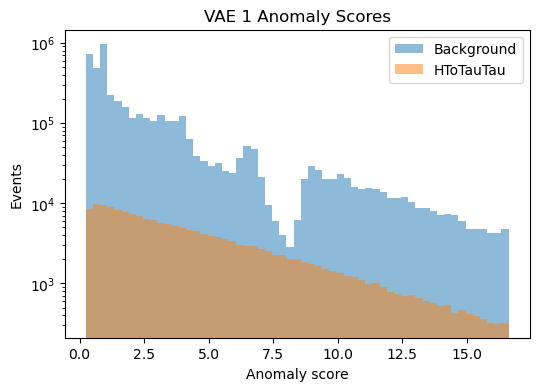

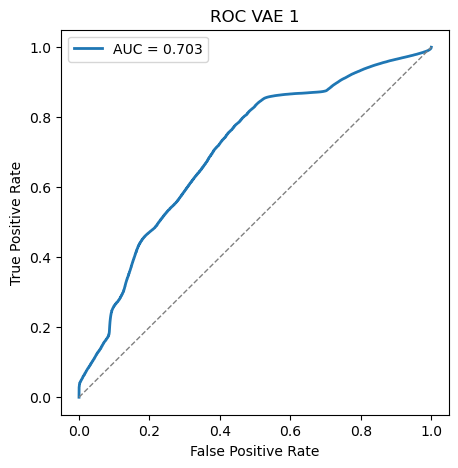

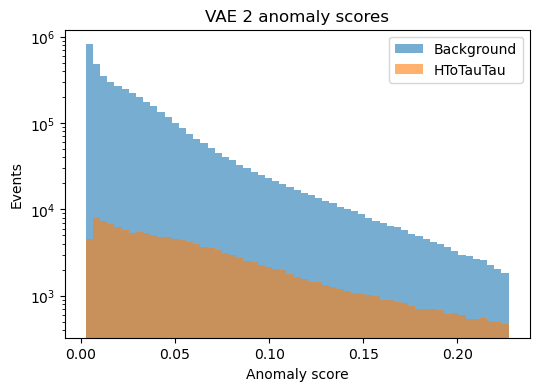

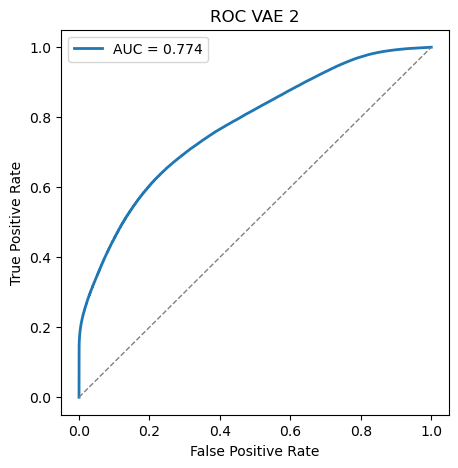

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#reload data same way as in traiining
print("Loading dataset...")
fpath = '/axovol/training/v5/conditionsupdate_apr25.h5'
with h5.File(fpath, 'r') as f:
    root = f['data'] if 'data' in f else f

    x_train = root['Background_data']['Train']['DATA'][:]
    x_test  = root['Background_data']['Test']['DATA'][:]
    print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

    #flatten per event
    x_train_bkg = x_train.reshape(x_train.shape[0], -1)
    x_test_bkg  = x_test.reshape(x_test.shape[0], -1)

    scale = root['Normalisation']['norm_scale'][:]
    bias  = root['Normalisation']['norm_bias'][:]

    l1_bits_bkg_test = root['Background_data']['Test']['L1bits'][:]

    #load signal data
    SIGNAL_NAMES = list(root['Signal_data'].keys())
    signal_data_dict = {}
    signal_l1_dict   = {}
    for sname in SIGNAL_NAMES:
        x_sig = root['Signal_data'][sname]['DATA'][:]
        x_sig = x_sig.reshape(x_sig.shape[0], -1)
        l1_bits = root['Signal_data'][sname]['L1bits'][:]
        signal_data_dict[sname] = x_sig
        signal_l1_dict[sname] = l1_bits

print("Data finished loading.")

features = x_test_bkg.shape[1]

# reload config based on training
cfg = {
    "features": features,
    "latent_dim": 8,         
    "encoder_config": {"nodes": [28, 14]}, 
    "decoder_config": {"nodes": [24, 32, 64, 128, features]}, 
    "alpha": 0.5,
    "beta": 0.5
}

vae_1 = VAE(cfg).to(device)
vae_2 = VAE(cfg).to(device)

#load model weights
vae_1.load_state_dict(torch.load("vae1_trained.pth", map_location=device))
vae_2.load_state_dict(torch.load("vae2_trained.pth", map_location=device))
vae_1.eval()
vae_2.eval()

#compute anomaly scores
bkg_scores_1 = distance_pt(vae_1, x_test_bkg, device)
sig_scores_1 = distance_pt(vae_1, x_sig, device)

bkg_scores_2 = distance_pt(vae_2, x_test_bkg, device)
sig_scores_2 = distance_pt(vae_2, x_sig, device)

#vae 1 anomaly score plot
plt.figure(figsize=(6,4))
bins = np.linspace(np.percentile(bkg_scores_1, 0.5), np.percentile(bkg_scores_1, 99.5), 60)
plt.hist(bkg_scores_1, bins=bins, alpha=0.5, label='Background')
plt.hist(sig_scores_1, bins=bins, alpha=0.5, label="HToTauTau")
plt.xlabel("Anomaly score"); plt.ylabel("Events"); plt.legend(); plt.title("VAE 1 Anomaly Scores")
plt.yscale('log')
plt.show()

#vae 1 ROC curve
y_true  = np.concatenate([np.zeros_like(bkg_scores_1), np.ones_like(sig_scores_1)])
y_score = np.concatenate([bkg_scores_1, sig_scores_1])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', lw=1, color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC VAE 1")
plt.legend()
plt.show()


#vae 2 anomaly score plot
plt.figure(figsize=(6,4))
bins = np.linspace(np.percentile(bkg_scores_2, 0.5), np.percentile(bkg_scores_2, 99.5), 60)
plt.hist(bkg_scores_2, bins=bins, alpha=0.6, label='Background')
plt.hist(sig_scores_2, bins=bins,alpha=0.6, label="HToTauTau")
plt.xlabel("Anomaly score"); plt.ylabel("Events"); plt.legend(); plt.title("VAE 2 anomaly scores")
plt.yscale('log')
plt.show()

#vae 2 ROC curve plot
y_true  = np.concatenate([np.zeros_like(bkg_scores_2), np.ones_like(sig_scores_2)])
y_score = np.concatenate([bkg_scores_2, sig_scores_2])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', lw=1, color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC VAE 2")
plt.legend()
plt.show()